<img src="https://s3.amazonaws.com/media-p.slid.es/uploads/1485763/images/9060062/Header.png" alt="Header" style="width: 800px;"/>

# Aprendizaje Automático de Máquina

Yiby Karolina Morales Pinto

```
💡Integrantes💡

✨Laura Sofía Ortiz Arcos
✨David Santiago Flórez Alsina
```    

<hr> </hr>

Abril 27, 2023

--------

## Antecedentes

_**Opcional:**_ Nuestra motivación para trabajar este problema es utilizar unos datos que recolectamos aproximadamente hace un año en el laboratorio Bardeen en la primera edición del proyecto de emprendimiento ___Maticas___.


<div style="display: flex; justify-content: center;">
    <img src="./albahaca_maticas_v3_heavy.png" alt="Header" style="width: 400px;"/>
</div>


***Maticas*** surge de ver cómo en *Colombia* se tratan de generar soluciones para ayudar al agricultor y permitirle ser más productivo, en un tiempo en el que se habla mucho de reformas agrarias y distribución de tierras, pero el debate no inicia oficialmente y menos el planteamiento de una solución y su implementación, mientras que a la vez las nuevas generaciones de personas que nacen en estas zonas rurales ya no quieren dedicarse a los campos ya que la ven como una actividad muy exaustiva y con poco retorno económico en comparación con lo que ofrece la ciudad. *Maticas* busca que a través de la tecnología se le pueda dar solución a parte del problema del agro que el estado aún no ha solucionado.


El inicio y actual propósito ***Maticas*** es ayudar al agricultor a *esforzarse menos* en su trabajo, obteniendo *mejores resultados*, permitiendo a todos los consumidores el tener *más variedad de plantas, de mejor calidad y mejor precio* para alimentarnos. Nuestro objetivo no solo busca fortalecer el agro en el sector rural, sino también en el urbarno, a través de huertas urbanas automatizadas con hidroponía que se puedan ubicar en distintos espacios y empresas.

En un futuro próximo buscamos incorporar inteligencia artificial para ayudar al agricultor a tomar acciones que protejan su cultivo, si por ejemplo pudieramos detectar que dentro de 48 horas va a haber una helada, se podrían tomar ciertas acciones que mitiguen los efectos sobre el cultivo, por ejemplo. Lo que buscamos con este proyecto es acercarnos un poco a esto.

Hay trabajos que hacen labores similares de predicción muchos de ellos usan redes neuronales recurrentes, sin embargo nosotros queremos probar una aproximación desde las redes neuronales sencillas y la extracción de caracterísisticas temporales, de nuestras señales.

links para hablar: 

- https://repositorio.uniandes.edu.co/bitstream/handle/1992/45458/u827540.pdf?sequence=1 

- https://upcommons.upc.edu/bitstream/handle/2117/108387/memoria-tfm-federico-aguilar-calvo.pdf?sequence=1&isAllowed=y

- http://somim.org.mx/memorias/memorias2020/articulos/A4_6.pdf

- https://oa.upm.es/11206/1/MARIA_GUADALUPE_CORTINA_JANUCHS.pdf



## Definición del problema

Se describe claramente el problema que se resolverá. El problema debe estar bien definido, debe ser cuantificable y medible.

_Nos planteamos solucionar la problemática de predecir humedad y temperatura ambiental usando redes neuronales y tensorflow, lo haremos con predicciones para 10 min, 15 min, 30 min y 60 min en el futuro_.

## Descripción de la solución

Descripción de cómo se abordará el problema. La estrategia planteada es aplicable al proyecto y apropiada para los datos dados. Adicionalmente, la solución es cuantificable y medible.

_Construir una red neuronal predictiva para los periodos de tiempo seleccionados, probaremos distintas arquitecturas y funciones de activación, para encontrar la mejor red de todas._

## Datos

El dataset a usar en el proyecto debe ser descrito detalladamente. Información acerca de dónde se obtuvo el dataset y sus características, debe ser incluída. Así como toda referencia utilizada.

Nuestro dataset se compone de las siguientes mediciones:
- Luz (lux). 
- Humedad relativa (%). 
- Tempertura ambiental (°C). 
- Presión atmosférica (mmHg).

Cada medición tiene un timestamp asociado que nos indica el instante en el que se midió.

## Modelo de referencia

Se debe hacer un experimento preliminar con un primer algoritmo, puede ser simple. Esto con el fin de obtener una primera aproximación al problema, la cual se deberá mejorar durante el proyecto.

In [23]:
import sklearn
import datetime          as dt
import pandas            as pd
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

from sklearn                 import preprocessing
from tensorflow              import keras
from datetime                import timedelta
from sklearn.model_selection import train_test_split

### Preprocesamiento de los datos

$$(1)$$ Indexamos cada dato con su timestamp en lugar de un índice numérico.

In [24]:
def separate_timestamp(df):
    """
    Converts the 'time' column in the input dataframe to a pandas datetime format.
    
    INPUT:
        - df: A pandas DataFrame with a 'time' column
    
    OUTPUT:
        - pd.DataFrame: A copy of the input dataframe with the 'time' column converted to pandas datetime format
    """
    
    # Convert the 'time' column to a pandas datetime format
    df['time'] = pd.to_datetime(df['time'])

    # Return the modified dataframe
    return df


$$(2)$$ Extraemos algunas características en intervalos de tiempo seleccionados por nosotros.

In [25]:

def calculate_rolling_average(df: pd.DataFrame, N: list, var: str):
    """
    Calculates rolling statistics of a specified variable for a given window size and adds them as new columns
    to the input dataframe.
    
    Args:
    - df (pandas DataFrame): input dataframe containing a column named 'time' and the variable of interest 
                             specified in the 'var' argument.
    - N (list of integers):  list of window sizes (in minutes) for which to calculate rolling statistics.
    - var (string):          name of the variable of interest for which to calculate rolling statistics.
    
    Returns:
    - pandas DataFrame:      modified dataframe with new columns added for the rolling statistics.
    """
    
    # Set the 'time' column as the dataframe index
    df.set_index('time', inplace=True)

    # Calculate the rolling statistics of the 'var' column for each window size in the list N
    for n in N:
        rolling_average   = df[var].rolling(f'{n}min').mean()
        rolling_variance  = df[var].rolling(f'{n}min').var()
        rolling_minimum   = df[var].rolling(f'{n}min').min()
        rolling_maximum   = df[var].rolling(f'{n}min').max()

        # Add the rolling statistics as new columns to the dataframe, filling NaN values with the next valid value
        df[f'avg_{n}min']  = rolling_average.bfill()
        df[f'var_{n}min']  = rolling_variance.bfill()
        df[f'max_{n}min']  = rolling_maximum.bfill()
        df[f'min_{n}min']  = rolling_minimum.bfill()

    # Return the modified dataframe
    return df


In [26]:
df = separate_timestamp( pd.read_csv('hum.csv') )
features = calculate_rolling_average(df, [10, 15, 30, 60], 'hum_level')

$$(3)$$ Escalamos nuestros datos para probar si nos dan mejores resultados.

In [27]:
def data_scaling(data: pd.DataFrame,
                 scaler: sklearn.preprocessing._data,
                 scaling_columns     = [], 
                 not_scaling_columns = [], 
                 dropping = False):
    
    """
    Scales the specified columns in the input DataFrame using the given scaler object.
    
    INPUT:
        - data:                Pandas DataFrame to be scaled
        - scaler:              Scaler object from sklearn.preprocessing
        - scaling_columns:     List of column names to scale
        - not_scaling_columns: List of column names to not scale
        
    OUTPUT: 
        - pd.DataFrame:        A scaled copy of the input data with the specified columns scaled
    """

    # if the user provided all the columns he wishes to scale 
    if scaling_columns:
        data[scaling_columns] = scaler.fit_transform(data[scaling_columns].to_numpy())

    # if user provided only the columns he doesn't want to scale
    elif not_scaling_columns:
        used_cols = data.columns.difference(not_scaling_columns)
        data.loc[:, used_cols] = scaler.fit_transform(data.loc[:, used_cols].to_numpy())

    else:
        data.iloc[:] = scaler.fit_transform(data.iloc[:].to_numpy())
    
    return data

$$(4)$$ Construimos la matrix $$Y$$ que es una lista de salidas que buscamos obtener con nuestra predicción, donde cada fila tiene 4 columnas y cada una es el valor en 10, 15, 30 y 60 minutos en el futuro para la humedad relativa.

In [28]:
def find_future_measurement(data: pd.DataFrame,
                            curr_measurement: pd.core.series.Series,
                            prediction_var: str,
                            N: list) -> tuple:
    """
    Takes a complete dataframe (data) and a row of this dataframe (curr_measurement), and finds the future measurements 
    for a given list of time intervals (N).
    
    INPUT:
        - data: A pandas DataFrame containing the measurement data
        - curr_measurement: A pandas Series containing a single row (measurement) of the DataFrame (data)
        - prediction_var: A string representing the name of the column containing the measurement to predict
        - N: A list of time intervals (in minutes) for which future measurements are to be predicted
        
    OUTPUT:
        - A tuple containing the future measurement values for each of the time intervals in N
    
    Example:
    If N = [30, 60], then the function will return a tuple containing the predicted measurements 30 and 60 minutes 
    into the future from the current measurement in curr_measurement.
    """
    
    # Take current measurement index (datetime)
    curr_idx = curr_measurement.name
    
    # Go n units into the future for n in N
    nearest_measurements = []
    
    for n in N:
        # Calculate the datetime n minutes into the future
        future_time = curr_idx + pd.Timedelta(minutes=n)
        
        # Calculate the time difference between each index in data and the future_time
        time_diff = abs(data.index - future_time)
        
        # Find the index of the row with the smallest time difference (i.e., closest measurement)
        nearest_idx = time_diff.argmin()
        
        # Get the row with the closest measurement and add the predicted measurement to the list
        nearest_time = data.iloc[nearest_idx]
        nearest_measurements.append(nearest_time[prediction_var])
    
    return tuple(nearest_measurements)


$$(5)$$ Integramos todo lo anterior en nuestra función build dataset.

In [29]:
def build_dataset(data: pd.DataFrame, N: list, prediction_var: str, scaler=None):
    """
    Builds a dataset for time series prediction by creating X and Y matrices from the input data.

    INPUT:
        - data:           Pandas DataFrame containing the input data
        - N:              List of integers representing the number of minutes into the future to predict for each sample
        - prediction_var: String representing the name of the column to predict
        - scaler:         Scaler object from sklearn.preprocessing to scale the input data

    OUTPUT:
        - Tuple of two numpy arrays: X matrix and Y matrix
    """

    # Get the last hour of measurement
    last_hour = data.tail(1).index[0] - pd.Timedelta(minutes=max(N))

    # Drop the last hour of data
    X = data.truncate(after=pd.Timestamp(last_hour))

    # Build the Y matrix (the future measurements)
    output_dims = (len(X), len(N))
    Y = np.zeros(output_dims)

    for i in range(len(X)):
        current = X.iloc[i].name
        Y[i, :] = find_future_measurement(data = X.truncate(after=current),
                                          N    = N,
                                          curr_measurement = X.iloc[i],
                                          prediction_var   = prediction_var)

    # Scale the data if requested
    if scaler is not None:
        X = data_scaling(data=X, scaler=scaler, not_scaling_columns=[prediction_var])

    # Use all the columns but the column we want to predict
    cols = X.columns.difference([prediction_var])

    return X[cols].to_numpy(), Y


$$(6)$$ Hacemos el train/test split para entrenar nuestro modelo.

In [71]:
N = [10, 15, 30, 50, 60]
X, Y = build_dataset( data = features,
                      N = N,
                      prediction_var = 'hum_level')

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size = 0.8,
                                                    shuffle = False,)
                                                    #random_state = 69,)


### Creación del modelo

$$(1)$$ Modelo secuencial con función de activación ReLu y métrica de pérdida 'mse'.

$$(2)$$ Configuración de hiperparámetros y entrenamiento del modelo, así como guardado de su historial para entender su evolución en el tiempo.

In [34]:
model =  keras.Sequential([ keras.layers.Dense(units=len(N)*4, activation='relu'),
                            keras.layers.Dense(units=len(N)*8, activation='relu'),
                            keras.layers.Dense(units=len(N)*16, activation='relu'),
                            keras.layers.Dense(units=5, activation='relu')])

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.01),
              loss = 'mse')

history = model.fit(X_train, y_train,
                    epochs           = 50, 
                    batch_size       = 3,
                    steps_per_epoch  = 1000,
                    validation_split = 0.10)
                    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 16.7140 - val_loss: 3.6091
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.3162 - val_loss: 0.9648
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 1.1390 - val_loss: 0.1475
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/step - loss: 1.0449 - val_loss: 0.0705
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.9222 - val_loss: 1.7257
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.8360 - val_loss: 1.6945
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7703 - val_loss: 0.1666
Epoch 8/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6792 - val_loss: 0.0351
Epoch 9/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6400 - val_loss: 0.1364
Epoch 10/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.61

In [35]:
def plot_loss(history):
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], 'g', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    #plt.xlim([0, 100])
    #plt.ylim([0, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

### Observación de resultados


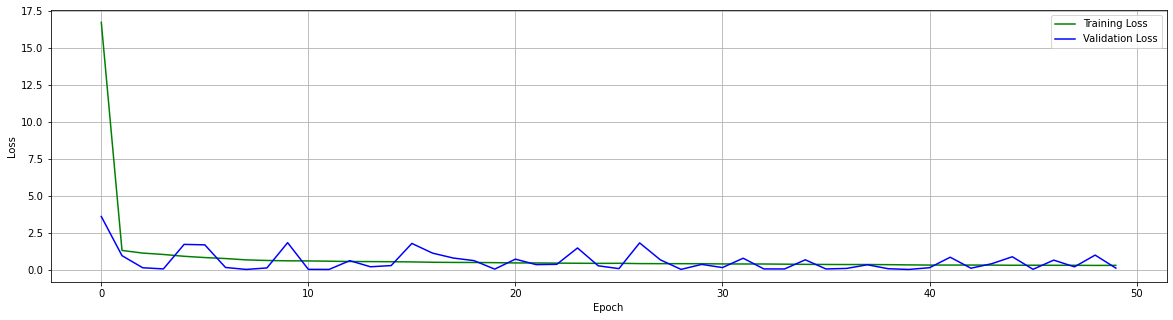

In [36]:
plot_loss(history)

In [37]:
y_pred = model.predict(X_test)

88/88 [==============================] - 0s 1ms/step


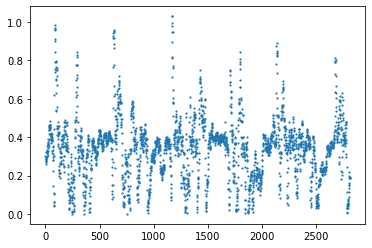

In [38]:
plt.scatter(list(range(len(y_test[:,0]))), abs(y_pred[:,0] - y_test[:,0]), s=1.3)


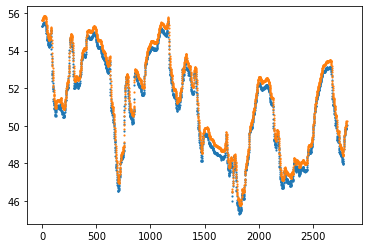

In [39]:
plt.scatter(list(range(len(y_test[:,0]))), y_test[:,3], s=1.3)
plt.scatter(list(range(len(y_pred[:,0]))), y_pred[:,3], s=1.3)


In [166]:
def plot_predictions3(model, X_test, y_test, N=[10, 15, 30, 50, 60]):
    y_pred = model.predict(X_test)
    mse = []
    
    for i in range(y_test.shape[1]):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(list(range(len(y_test[:,i]))), y_test[:,i], s=1.3)
        ax1.scatter(list(range(len(y_pred[:,i]))), y_pred[:,i], s=1.3)
        ax1.legend(['True', 'Predicted'])
        ax1.set_title(f"True vs. Predicted values - {N[i]} min in the future")
        
        ax2.scatter(list(range(len(y_test[:,i]))), abs(y_pred[:,i] - y_test[:,i]), s=1.3)
        ax2.set_title(f"Error - {N[i]} min in the future")
        
        plt.show()
        
        mse_i = np.mean(np.abs(y_pred[:,i] - y_test[:,i]))
        mse.append(mse_i)
        print(f'MSE para {N[i]} min en el futuro: {mse_i}')

    #return mse


88/88 [==============================] - 0s 1ms/step


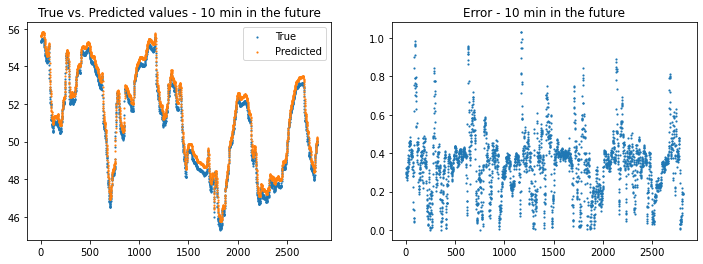

MSE para 10 min en el futuro: 0.3383976318945625


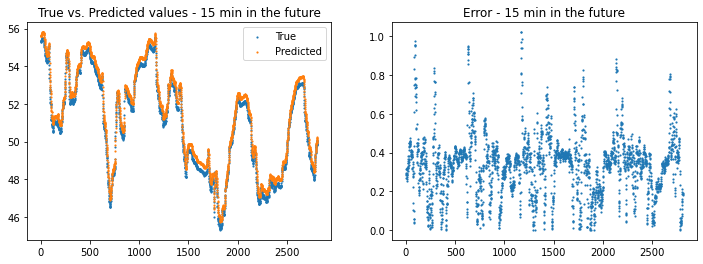

MSE para 15 min en el futuro: 0.33194575328413006


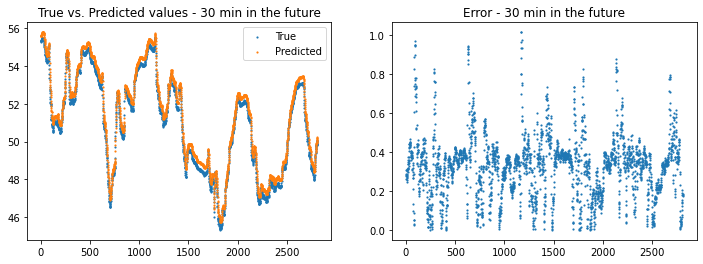

MSE para 30 min en el futuro: 0.32555310168244245


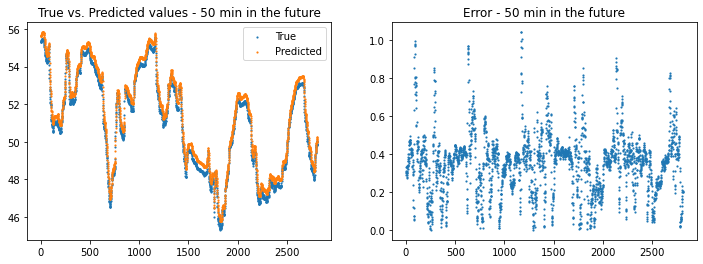

MSE para 50 min en el futuro: 0.34980892397169117


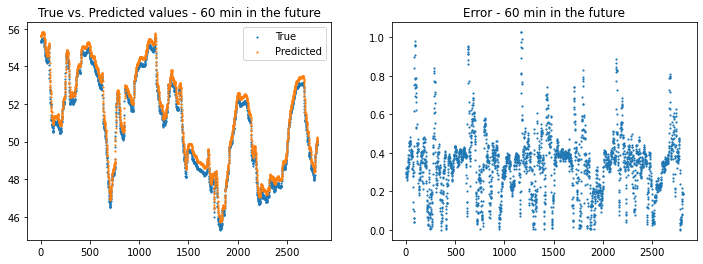

MSE para 60 min en el futuro: 0.33583302973174234


In [167]:
N = [10, 15, 30, 50, 60]
a = plot_predictions3(model, X_test, y_test, N)
a

In [15]:
!!pip install -q -U keras-tuner

['WARNING: You are using pip version 22.0.4; however, version 23.1.2 is available.',
 "You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command."]

In [16]:
import tensorflow  as tf
import keras_tuner as kt

from tensorflow import keras


In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=16, max_value=116, step=10)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [186]:
def prepare_data(csv_files: list): 

    data = [pd.read_csv(f) for f in csv_files]
    out  = [] 

    # Convert the 'time' column to a pandas datetime format
    for df in data:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True) 
        out.append(df)

    return out

In [198]:
def build_dataset_expanded(data: list, N: list, prediction_var: str, scaler=None):

    """
    Builds a dataset for time series prediction by creating X and Y matrices from the input data.

    INPUT:
        - data:           List of Pandas DataFrames containing the input data for each ambien variable
        - N:              List of integers representing the number of minutes into the future to predict for each sample
        - prediction_var: String representing the name of the column to predict
        - scaler:         Scaler object from sklearn.preprocessing to scale the input data

    OUTPUT:
        - Tuple of two numpy arrays: X matrix and Y matrix
    """
    
    for i in range(len(data)):
        data[i].index = pd.to_datetime(data[i].index)

    # Get the earliest timestamp t_0
    t_0 = min([df.index.min() for df in data])

    # Get the latest timestamp t_f
    t_f = max([df.index.max() for df in data])

    # Get the smallest sampling period of the variable (T)
    T = min([df.index[1] - df.index[0] for df in data])

    # Build a time vector from t_0 until t_f (with stepsize of T)
    time_vector = pd.date_range(t_0, t_f, freq=T)
    
    print(t_0, t_f, T, time_vector)


    X = []
    Y = []

    # For each timestamp in the time vector
    for timestamp in time_vector:
        features = []

        # Find the nearest measurement to the timestamp and extract the features
        for df in data:
            nearest_measurement = df.iloc[(df.index - timestamp).abs().argmin()]
            features.extend(nearest_measurement.values)

        # Pack the resulting features from all variables and store it into the nth row of the X matrix
        X.append(features)

        # Get the corresponding prediction target Y
        prediction_time = timestamp + pd.Timedelta(minutes=N)
        nearest_measurement = data[0].iloc[(data[0].index - prediction_time).abs().argsort()[0]]
        target_value = nearest_measurement[prediction_var]
        Y.append(target_value)

    # Convert X and Y to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Scale the input data using the provided scaler
    if scaler is not None:
        X = scaler.transform(X)

    return X, Y



In [199]:
data = prepare_data(csv_files = ['hum.csv', 'lux.csv', 'pressure.csv', 'temp.csv'])
N=[10, 15, 30, 50, 60]
build_dataset_expanded(data, N, 'a')

2022-05-09 21:22:17 2022-06-12 14:22:22 0 days 00:02:30 DatetimeIndex(['2022-05-09 21:22:17', '2022-05-09 21:24:47',
               '2022-05-09 21:27:17', '2022-05-09 21:29:47',
               '2022-05-09 21:32:17', '2022-05-09 21:34:47',
               '2022-05-09 21:37:17', '2022-05-09 21:39:47',
               '2022-05-09 21:42:17', '2022-05-09 21:44:47',
               ...
               '2022-06-12 13:59:47', '2022-06-12 14:02:17',
               '2022-06-12 14:04:47', '2022-06-12 14:07:17',
               '2022-06-12 14:09:47', '2022-06-12 14:12:17',
               '2022-06-12 14:14:47', '2022-06-12 14:17:17',
               '2022-06-12 14:19:47', '2022-06-12 14:22:17'],
              dtype='datetime64[ns]', length=19417, freq='150S')


AttributeError: 'TimedeltaIndex' object has no attribute 'abs'

## Métricas

Se propone al menos una métrica de evaluación para cuantificar el desempeño del modelo. Las métricas propuestas son apropiadas para el problema. Un resumen del flujo de trabajo para abordar el proyecto. Se comentan estrategias a utilizar, qué análisis de los datos se podría requerir o qué algoritmos se considerarán.

### Estrategias y flujo de trabajo

1. Preprocesamiento de datos, esto es: 
    - Extracción de características _(dada la naturaleza temporal de los datos, exploramos la extracción de características en intervalos de 10, 15, 30 y 60 minutos, para ayudar a nuestro modelo a hacer predicciones, sin recurrir a arquitecturas más complejas)_.
    -  Escalamiento de datos (vamos a probar si es mejor con o sin este escalamiento).
    - Combinación de las distintas bases de datos de mediciones de variables ambientales _(en la prueba de concepto presentada anteriormente se hizo uso únicamente de los datos de humedad para predecir los datos futuros de humedad, sin embargo queremos explorar si el incluir la influencia de otras variables ambientales nos ayuda a mejorar el resultado)_.

2. Construcción de distintas redes neuronales:
    - Con arquitecturas diferentes.
    - Funciones de activación diferentes.
    - Hiperparámetros diferentes. 

Tooodo esto para encontrar la mejor red neuronal, de hecho vamos a hacer el top 3 de las mejores redes neuronales y trataremos de deducir algunas concluciones de sus arquitecturas e hiperparámetros en relación con los datos. 

3. Comparación con los resultados de la red neuronal que solo hace uso de las características de la variable de predicción, con la red que hace uso de otros datos ambientales.

Vamos a hacer uso de las siguientes métricas:

- MSE (Mean Squared Error)
- MAE (Mean Absolute Error) 
- RMSE (Root Mean Squared Error) 

Estas métricas son apropiadas para evaluar el desempeño de un modelo en problemas de regresión, ya que miden la diferencia entre los valores predichos y los valores reales de la variable objetivo.

MSE mide el promedio del cuadrado de los errores, mientras que MAE mide el promedio de los errores en valor absoluto. RMSE es similar a MSE, pero toma la raíz cuadrada del promedio de los errores al cuadrado.

Además, son adecuadas para nuestro problema porque estamos interesados en predecir valores continuos, como la temperatura, la presión, la humedad y la luz. Y también, son fáciles de entender y comunicar, y permiten comparar el desempeño de diferentes modelos.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff9b19c4-718d-4116-a04b-62cd53a598e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>